# Windows implemented:
 
* Brain Matter window : W: 80 L: 40
* Blood/subdural window: W: 130-300 L: 50-100
* Soft tissue window: W: 350–400 L: 20–60
* Bone window: W: 2800 L: 600


In [11]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import pydicom
import os

print('Loaded in libraries!')

Loaded in libraries!


In [12]:
TRAIN_IMG_PATH = "../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train/"
TEST_IMG_PATH = "../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_test/"
BASE_PATH = '/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/'
TRAIN_DIR = 'stage_2_train/'
TEST_DIR = 'stage_2_test/'

train = pd.read_csv("../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train.csv")
sub = pd.read_csv("../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_sample_submission.csv")
train_images = os.listdir("../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train/")
test_images = os.listdir("../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_test/")

def window_image(img, window_center,window_width, intercept, slope, rescale=True):

    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    
    if rescale:
        # Extra rescaling to 0-1, not in the original notebook
        img = (img - img_min) / (img_max - img_min)
    
    return img
    
def get_first_of_dicom_field_as_int(x):
    
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

    
    
def view_images(images, title = '', aug = None):
    width = 6
    height = 2
    fig, axs = plt.subplots(height, width, figsize=(15,6))
    
    for im in range(0, height * width):
        data = pydicom.read_file(os.path.join(TRAIN_IMG_PATH,'ID_'+images[im]+ '.dcm'))
        image = data.pixel_array
        window_center , window_width, intercept, slope = get_windowing(data)
        image_windowed = window_image(image, window_center, window_width, intercept, slope)


        i = im // width
        j = im % width
        axs[i,j].imshow(image_windowed, cmap=plt.cm.bone) 
        axs[i,j].axis('off')
        
    plt.suptitle(title)
    plt.show()

In [13]:
#split out information to type and patientID

train['type'] = train['ID'].str.split("_", n = 3, expand = True)[2]
train['PatientID'] = train['ID'].str.split("_", n = 3, expand = True)[1]
train['filename'] = train['ID'].apply(lambda st: "ID_" + st.split('_')[1] + ".png")

sub['filename'] = sub['ID'].apply(lambda st: "ID_" + st.split('_')[1] + ".png")
sub['type'] = sub['ID'].apply(lambda st: st.split('_')[2])


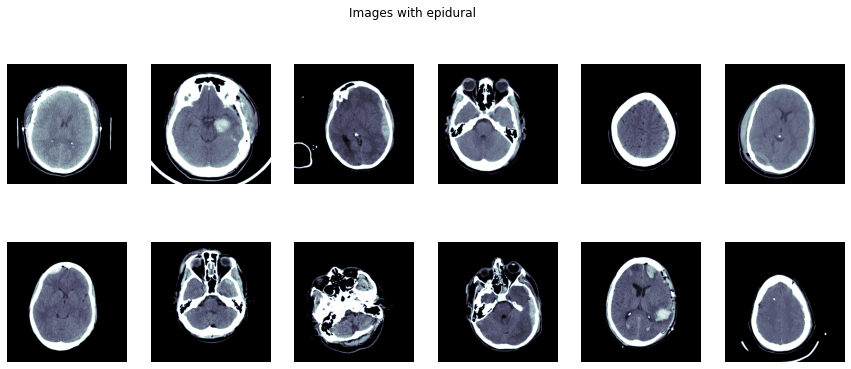

In [14]:
view_images(train[(train['type'] == 'epidural') & (train['Label'] == 1)][:12].PatientID.values, title = 'Images with epidural')

In [15]:
train[(train['type'] == 'subdural') & (train['Label'] == 1)][:10]

,ID,Label,type,PatientID,filename
172,ID_85f1fa3bd_subdural,1,subdural,85f1fa3bd,ID_85f1fa3bd.png
184,ID_4598fa77a_subdural,1,subdural,4598fa77a,ID_4598fa77a.png
208,ID_4c45dcf36_subdural,1,subdural,4c45dcf36,ID_4c45dcf36.png
358,ID_8927bc6ee_subdural,1,subdural,8927bc6ee,ID_8927bc6ee.png
442,ID_945b3f1e4_subdural,1,subdural,945b3f1e4,ID_945b3f1e4.png
514,ID_568242d1d_subdural,1,subdural,568242d1d,ID_568242d1d.png
736,ID_3e9f3c8d5_subdural,1,subdural,3e9f3c8d5,ID_3e9f3c8d5.png
1012,ID_891e96ff3_subdural,1,subdural,891e96ff3,ID_891e96ff3.png
1108,ID_758c3c2f3_subdural,1,subdural,758c3c2f3,ID_758c3c2f3.png
1114,ID_3c300c405_subdural,1,subdural,3c300c405,ID_3c300c405.png


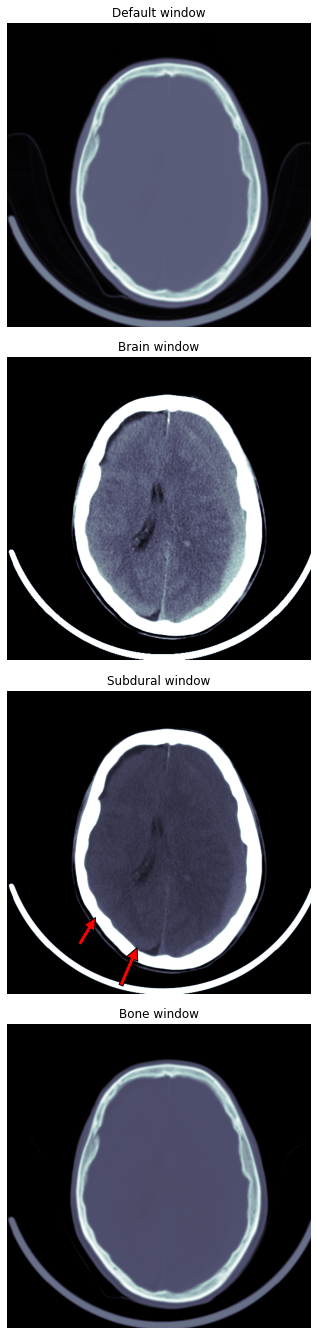

../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train/ID_6ef1c9a94.dcm


In [16]:
## ID_6ef1c9a94 good subdural

case = os.path.join(TRAIN_IMG_PATH,'ID_6ef1c9a94.dcm')

data = pydicom.read_file(case)

#print(data)
window_center , window_width, intercept, slope = get_windowing(data)
img = pydicom.read_file(case).pixel_array

#displaying the image

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex='col', figsize=(10,24), gridspec_kw={'hspace': 0.1, 'wspace': 0})

ax1.set_title('Default window')
im1 = ax1.imshow(img,  cmap=plt.cm.bone)

ax2.set_title('Brain window')
img2 = window_image(img, 40, 80, intercept, slope)
im2 = ax2.imshow(img2, cmap=plt.cm.bone)

ax3.set_title('Subdural window')
img3 = window_image(img, 80, 200, intercept, slope)
im3 = ax3.imshow(img3, cmap=plt.cm.bone)
ax3.annotate('', xy=(150, 380), xytext=(120, 430),
            arrowprops=dict(facecolor='red', shrink=0.05),
            )
ax3.annotate('', xy=(220, 430), xytext=(190, 500),
            arrowprops=dict(facecolor='red', shrink=0.05),
            )


ax4.set_title('Bone window')
img4 = window_image(img, 600, 2800, intercept, slope)
im4 = plt.imshow(img4, cmap=plt.cm.bone)

for ax in fig.axes:
    ax.axis("off")
    
plt.show()
print(case)

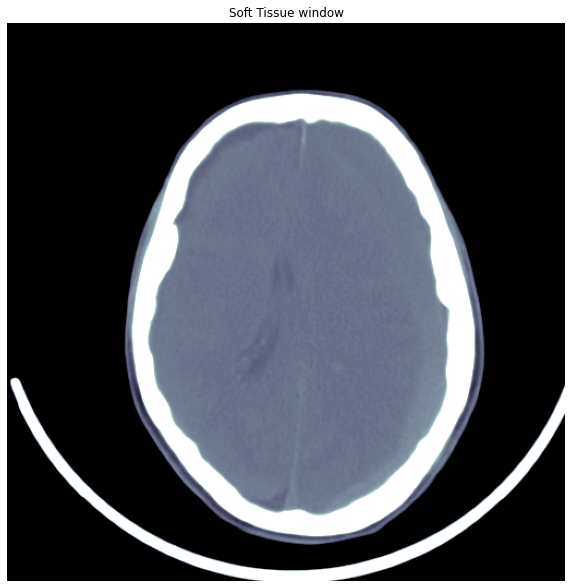

../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train/ID_6ef1c9a94.dcm


In [17]:
fig, (ax5) = plt.subplots(1,1, sharex='col', figsize=(10,24), gridspec_kw={'hspace': 0.1, 'wspace': 0})
ax5.set_title('Soft Tissue window')
img5 = window_image(img, 40, 380, intercept, slope)
im5 = plt.imshow(img5, cmap=plt.cm.bone)
for ax in fig.axes:
    ax.axis("off")
    
plt.show()
print(case)
